In [1]:
import anndata
import scvelo as scv
import numpy as np
from scipy.stats import poisson
from pyrovelocity.api import train_model
from pyrovelocity.plot import plot_posterior_time, plot_gene_ranking,\
      vector_field_uncertainty, plot_vector_field_uncertain,\
      plot_mean_vector_field, project_grid_points,rainbowplot,denoised_umap,\
      us_rainbowplot, plot_arrow_examples
import os
import argparse
import time
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2

# Discrete Model
## 1. Data Preparation

In [2]:
dataset = 'IO_EU'
root = '/scratch/blaauw_root/blaauw1/gyichen'
data_path_base = f'{root}/data'
adata = anndata.read_h5ad(f"{data_path_base}/{dataset}_pp.h5ad")
adata.layers['raw_spliced']   = adata.layers['spliced']
adata.layers['raw_unspliced'] = adata.layers['unspliced']
adata.obs['u_lib_size_raw'] = adata.layers['raw_unspliced'].toarray().sum(-1)
adata.obs['s_lib_size_raw'] = adata.layers['raw_spliced'].toarray().sum(-1)

## 2. Train the model with a specific configuration

In [3]:
num_epochs = 4000
batch_size = -1
likelihood = 'Poisson'
input_type = 'raw'
train_size = 0.7

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 3806 cells, 1000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3806  │
│             Vars             │ 1000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
train_faster_with_batch
step    1 loss = 1.96559e+07 patience = 45
step  100 loss = 1.40319e+07 patience = 45
step  200 loss = 1.17344e+07 patience = 44
step  300 loss = 9.9076e+06 patience = 44
step  400 loss = 8.38857e+06 patience = 45
step  500 loss = 7.14656e+06 patience = 45
step  600 loss = 6.23415e+06 patience = 43
step  700 loss = 5.79185e+06 patience = 44
step  800 loss = 5.55551e+06 patience = 44
step  900 loss = 5.37926e+06 patience = 45
step 1000 loss = 5.40676e+06 patience = 44
step 1100 loss = 5.37779e+06 patience = 43
step 1200 loss = 5.33173e+06 patience = 43
step 1300 loss = 5.30442e+06 patience = 45
step 1400 loss = 5.23066e+06 patience = 44
step 1500 loss = 5.21591e+06 patience = 45
step 1600 loss = 5.20347e+06 patience = 44
step 1700 loss = 5.19928e+06 patience = 45
step 1800 loss = 5.09567e+06 patience = 44
step 1900 loss = 5.11817e+06 patience = 45
step 2000 loss = 5.0392e+06 patience = 45
step 2100 loss = 5.10185e+06 patience =

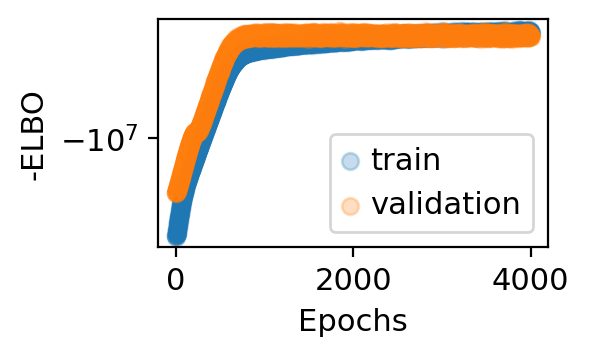

In [4]:
t_start = time.time()
pos_train, pos_test, train_idx, test_idx = train_model(adata,
                                                       max_epochs=num_epochs, 
                                                       svi_train=True, 
                                                       log_every=100,
                                                       patient_init=45,
                                                       batch_size=batch_size, 
                                                       use_gpu=0, 
                                                       likelihood=likelihood,
                                                       input_type=input_type,
                                                       cell_state='clusters',
                                                       include_prior=True,
                                                       offset=False,
                                                       library_size=True,
                                                       patient_improve=1e-3,
                                                       seed=2022,
                                                       guide_type='auto_t0_constraint',
                                                       train_size=train_size)
run_time = time.time()-t_start

## 3. Combine the results

In [5]:
pos = {}
for key in pos_train:
    n_sample = pos_train[key].shape[0]
    if(pos_train[key].shape[1]>1 and pos_train[key].shape[2]>1):
        val = np.zeros((n_sample, adata.n_obs, adata.n_vars))
        val[:,train_idx] = pos_train[key]
        val[:,test_idx] = pos_test[key]
        pos[key] = val
    elif(pos_train[key].shape[2]==1):
        val = np.zeros((n_sample, adata.n_obs, 1))
        val[:,train_idx] = pos_train[key]
        val[:,test_idx] = pos_test[key]
        pos[key] = val
    else:
        pos[key] = pos_train[key]

## 4. Compute Velocity

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 2/40 cores)


  0%|          | 0/3806 [00:00<?, ?cells/s]

    finished (0:00:47) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


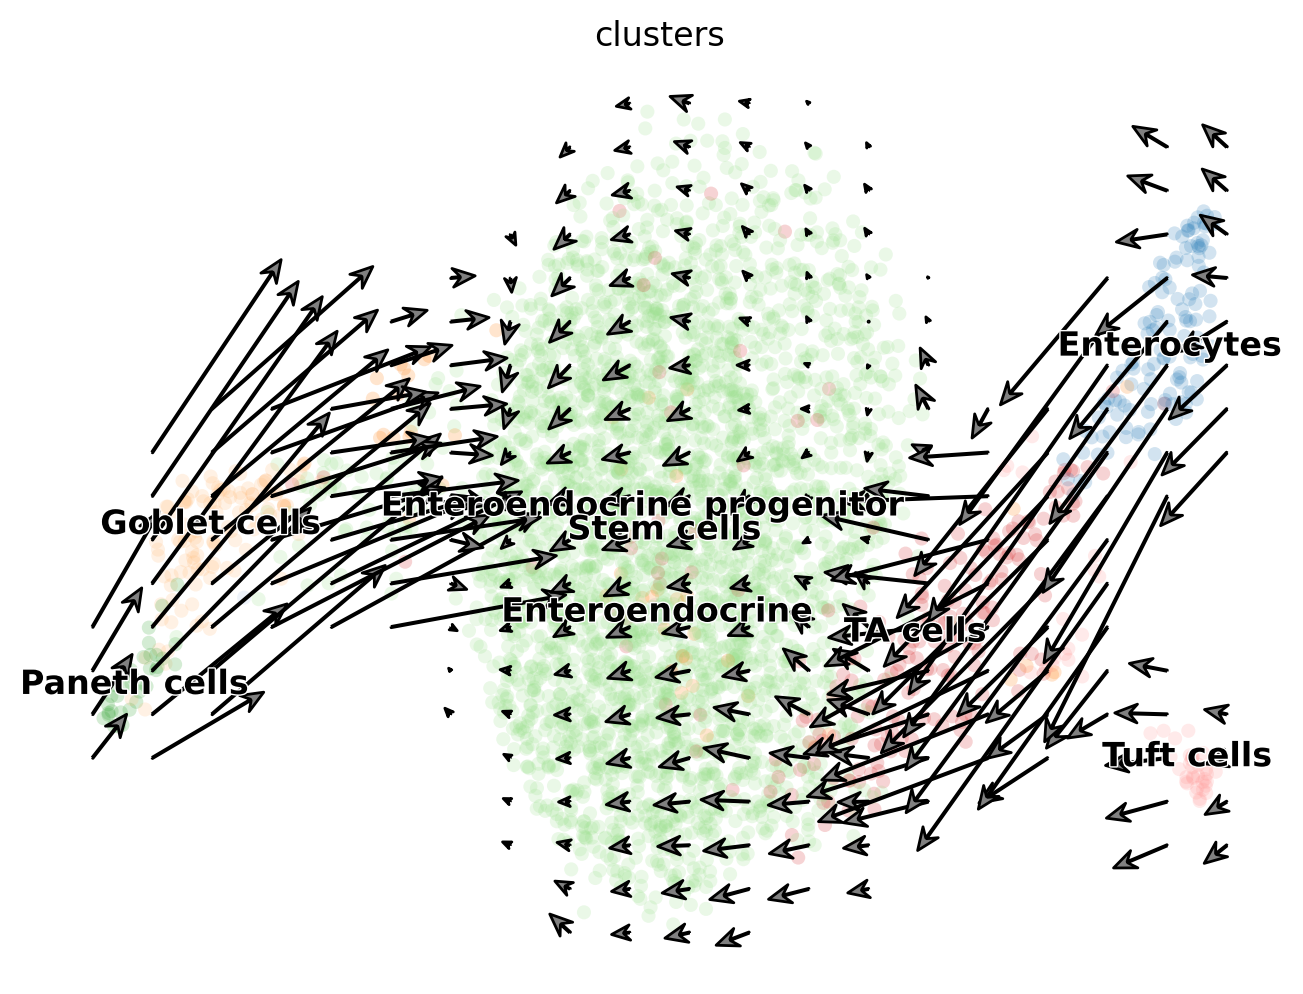

In [6]:
#Compute velocity
embed = "umap"
figure_path = f'{root}/figures/{dataset}'

fig, ax = plt.subplots(figsize=(8, 6))
embed_mean = plot_mean_vector_field(pos,
                                    adata,
                                    ax=ax,
                                    basis=embed,
                                    n_jobs=(adata.n_obs)//2000+1)

## 5. Compute performance metrics and save results

In [7]:
def save_fitting(adata, pos_train, train_idx, pos_test=None, test_idx=None):
    split = not ((pos_test is None) or (test_idx is None))
    for key in pos_train:
        k,m,n = pos_train[key].shape
        if(m>1 and n>1):
            adata.layers[f'pv_{key}'] = np.zeros((adata.n_obs,n))
            adata.layers[f'pv_{key}'][train_idx] = pos_train[key].mean(0)
            if(split):
                adata.layers[f'pv_{key}'][test_idx] = pos_test[key].mean(0)
        elif(m>1):
            adata.obs[f'pv_{key}'] = np.zeros((adata.n_obs))
            adata.obs[f'pv_{key}'][train_idx] = pos_train[key].mean(0).squeeze()
            if(split):
                adata.obs[f'pv_{key}'][test_idx] = pos_test[key].mean(0).squeeze()
        elif(n>1):
            adata.var[f'pv_{key}'] = pos_train[key].mean(0).squeeze()
        else:
            adata.uns[f'pv_{key}'] = pos_train[key]

In [8]:
adata.obsm[f"pv_velocity_{embed}"] = embed_mean
del adata.obsm[f"velocity_pyro_{embed}"]
adata.layers["pv_shat"] = adata.layers["spliced_pyro"]
adata.layers["pv_uhat"] = np.zeros(adata.shape)
adata.layers["pv_uhat"][train_idx] = pos_train["u"].mean(0)
adata.layers["pv_uhat"][test_idx] = pos_test["u"].mean(0)
del adata.layers["spliced_pyro"]
adata.layers["pv_velocity"] = adata.layers["velocity_pyro"]
del adata.layers["velocity_pyro"]

adata.obs['pv_time'] = pos['cell_time'][:,:,0].mean(0).squeeze()
adata.uns['pv_train_idx'] = train_idx
adata.uns['pv_test_idx'] = test_idx
save_fitting(adata, pos_train, train_idx, pos_test, test_idx)

err_dic = {}
mse_train, mse_test, mae_train, mae_test, logp_train, logp_test = 0,0,0,0,0,0

for i in range(n_sample):
    dist_u_train = np.abs(adata.layers['raw_unspliced'][train_idx].A-pos_train['u'][i])
    dist_s_train = np.abs(adata.layers['raw_spliced'][train_idx].A-pos_train['s'][i])
    dist_u_test = np.abs(adata.layers['raw_unspliced'][test_idx].A-pos_test['u'][i])
    dist_s_test = np.abs(adata.layers['raw_spliced'][test_idx].A-pos_test['s'][i])
    mse_train += np.mean(dist_u_train**2+dist_s_train**2)
    mse_test += np.mean(dist_u_test**2+dist_s_test**2)
    mae_train += np.mean(dist_u_train+dist_s_train)
    mae_test += np.mean(dist_u_test+dist_s_test)
    logp_train += np.log(poisson.pmf(adata.layers['raw_unspliced'][train_idx].A, pos_train['ut'][i])+1e-10).sum(1).mean()\
                 +np.log(poisson.pmf(adata.layers['raw_spliced'][train_idx].A, pos_train['st'][i])+1e-10).sum(1).mean()
    logp_test += np.log(poisson.pmf(adata.layers['raw_unspliced'][test_idx].A, pos_test['ut'][i])+1e-10).sum(1).mean()\
                 +np.log(poisson.pmf(adata.layers['raw_spliced'][test_idx].A, pos_test['st'][i])+1e-10).sum(1).mean()

In [9]:
err_dic['MSE Train'] = mse_train / n_sample
err_dic['MSE Test'] = mse_test / n_sample
err_dic['MAE Train'] = mae_train / n_sample
err_dic['MAE Test'] = mae_test / n_sample
err_dic['LL Train'] = logp_train / n_sample
err_dic['LL Test'] = logp_test / n_sample
adata.uns['err'] = err_dic

In [10]:
err_dic

{'MSE Train': 2.5183193443443446,
 'MSE Test': 1.8667081727962638,
 'MAE Train': 0.6490081831831832,
 'MAE Test': 0.629833216579101,
 'LL Train': -2434.4527879125135,
 'LL Test': -2447.4146467852847}

## Write to disk and plot results

In [11]:
data_path = f'{data_path_base}/pyro/discrete/{dataset}'
os.makedirs(data_path, exist_ok=True)
adata.write_h5ad(f'{data_path}/{dataset}.h5ad')

                    MAE
label                  
Poisson train  0.324504
Poisson valid  0.314917


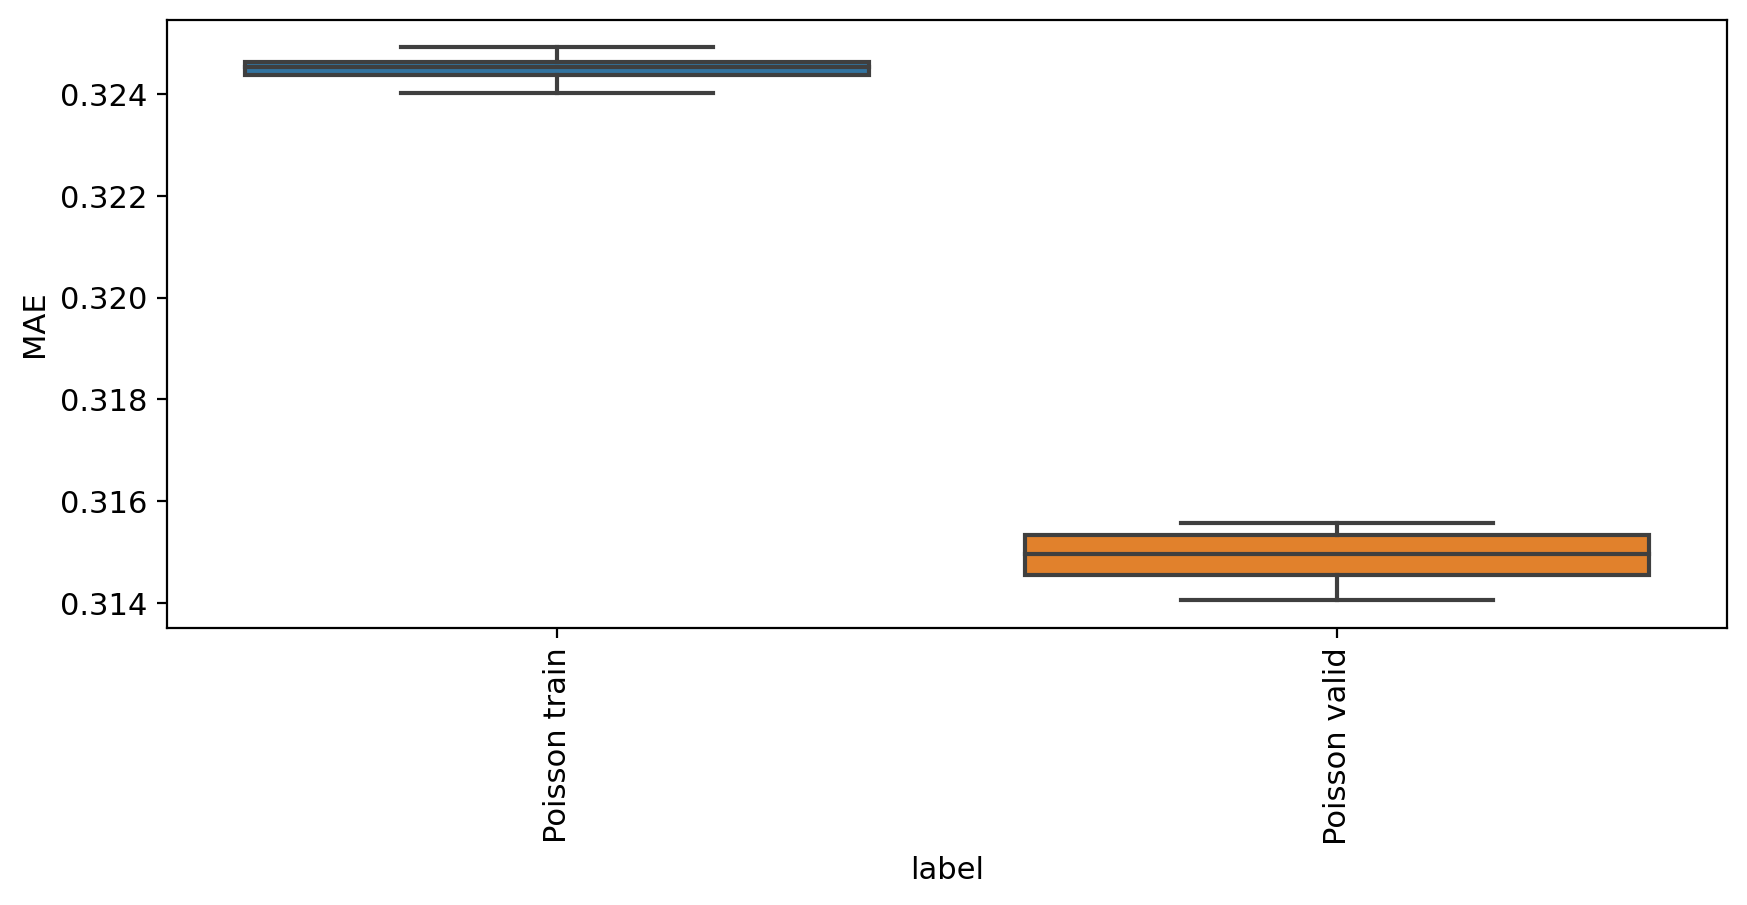

In [12]:
from pyrovelocity.utils import mae_evaluate
out = mae_evaluate((pos_train, pos_test, train_idx, test_idx), adata)

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/IO_EU/pv_vel_stream.png


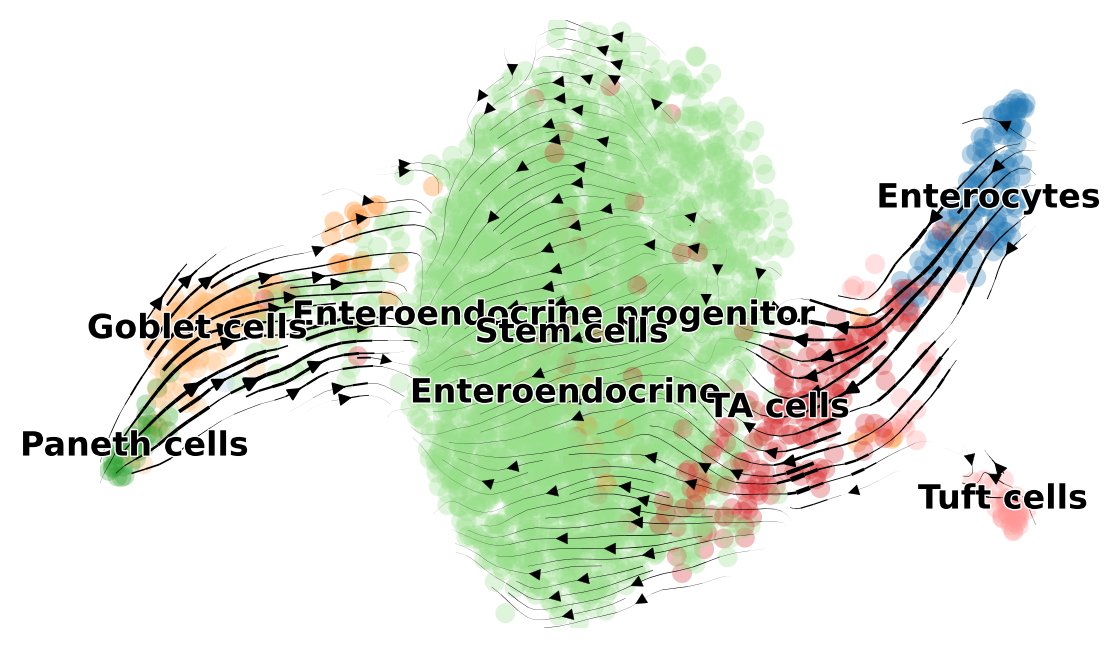

In [13]:
scv.pl.velocity_embedding_stream(adata,
                                 basis=embed,
                                 title='',
                                 vkey='pv_velocity',
                                 save=f'{figure_path}/pv_vel_stream.png')

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/IO_EU/pv_time.png


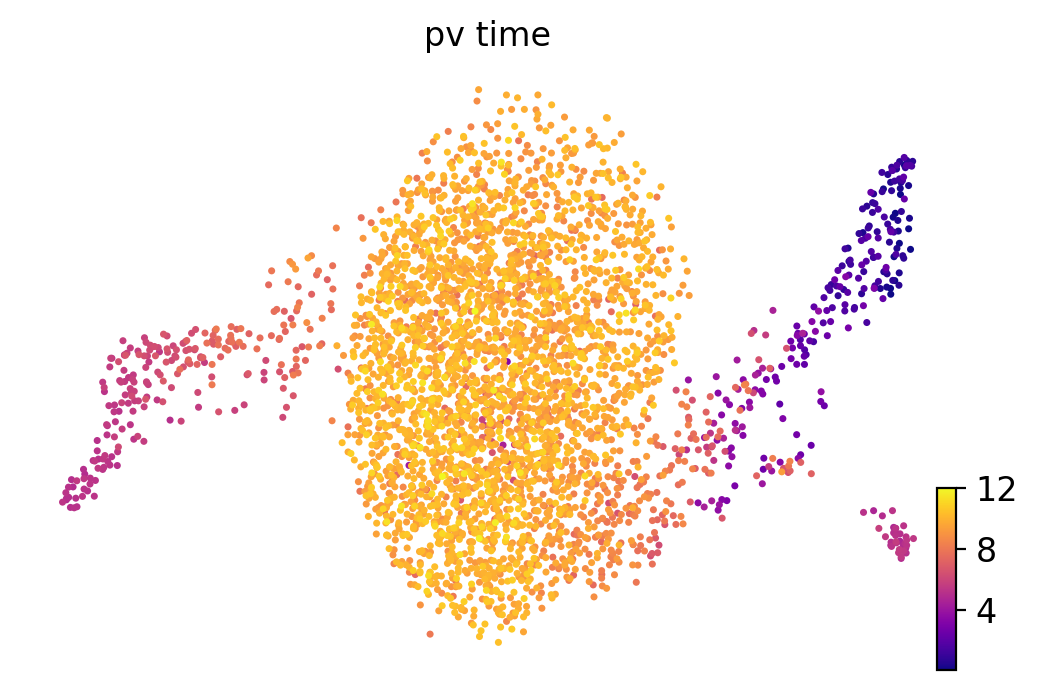

In [14]:
scv.pl.scatter(adata, basis=embed, color='pv_time', color_map='plasma', dpi=100, save=f'{figure_path}/pv_time.png')

In [15]:
del adata

# Continuous Model
## 1. Prepare Data

In [16]:
dataset = 'IO_EU'
root = '/scratch/blaauw_root/blaauw1/gyichen'
data_path_base = f'{root}/data'
adata = anndata.read_h5ad(f"{data_path_base}/{dataset}_pp.h5ad")

## 2. Train the model with a specific configuration

In [17]:
num_epochs = 4000
batch_size = -1
likelihood = 'Normal'
input_type = 'knn'
train_size = 0.7

INFO     No batch_key inputted, assuming all cells are same batch                                                  


INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["Mu"]                                                                        


INFO:scvi.data._anndata:Using data from adata.layers["Mu"]


INFO     Using data from adata.layers["Ms"]                                                                        


INFO:scvi.data._anndata:Using data from adata.layers["Ms"]


INFO     Successfully registered anndata object containing 3806 cells, 1000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 3806 cells, 1000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3806  │
│             Vars             │ 1000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │      adata.layers['Ms']       │
│        U         │      adata.layers['Mu']       │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
train_faster_with_batch
step    1 loss = 1.37444e+07 patience = 45
step  100 loss = 3.28041e+06 patience = 45
step  200 loss = -1.58923e+06 patience = 44
step  300 loss = -4.29975e+06 patience = 45
step  400 loss = -5.41607e+06 patience = 45
step  500 loss = -5.88397e+06 patience = 43
step  600 loss = -6.31609e+06 patience = 44
step  700 loss = -6.6011e+06 patience = 45
step  800 loss = -6.85074e+06 patience = 45
step  900 loss = -7.02202e+06 patience = 45
step 1000 loss = -7.08328e+06 patience = 45
step 1100 loss = -7.19088e+06 patience = 45
step 1200 loss = -7.24218e+06 patience = 45
step 1300 loss = -7.27999e+06 patience = 45
step 1400 loss = -7.30413e+06 patience = 45
step 1500 loss = -7.32842e+06 patience = 45
step 1600 loss = -7.34256e+06 patience = 45
step 1700 loss = -7.35277e+06 patience = 45
step 1800 loss = -7.35735e+06 patience = 45
step 1900 loss = -7.36222e+06 patience = 45
step 2000 loss = -7.36431e+06 patience = 45
step 2100 loss = -7

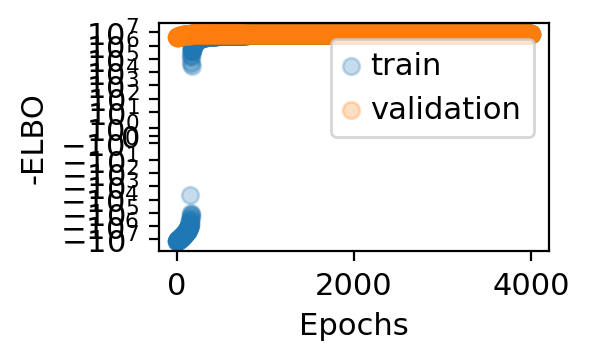

In [18]:
t_start = time.time()
pos_train, pos_test, train_idx, test_idx = train_model(adata,
                                                       max_epochs=num_epochs, 
                                                       svi_train=True, 
                                                       log_every=100,
                                                       patient_init=45,
                                                       batch_size=batch_size, 
                                                       use_gpu=0, 
                                                       likelihood=likelihood,
                                                       input_type=input_type,
                                                       cell_state='clusters',
                                                       include_prior=True,
                                                       offset=False,
                                                       library_size=True,
                                                       patient_improve=1e-3,
                                                       seed=2022,
                                                       guide_type='auto_t0_constraint',
                                                       train_size=train_size)
run_time = time.time()-t_start

## 3. Combine the results

In [19]:
#Combine the results
pos = {}
for key in pos_train:
    n_sample = pos_train[key].shape[0]
    if(pos_train[key].shape[1]>1 and pos_train[key].shape[2]>1):
        val = np.zeros((n_sample, adata.n_obs, adata.n_vars))
        val[:,train_idx] = pos_train[key]
        val[:,test_idx] = pos_test[key]
        pos[key] = val
    elif(pos_train[key].shape[2]==1):
        val = np.zeros((n_sample, adata.n_obs, 1))
        val[:,train_idx] = pos_train[key]
        val[:,test_idx] = pos_test[key]
        pos[key] = val
    else:
        pos[key] = pos_train[key]
pos['ut'] = pos['u']
pos['st'] = pos['s']

## 4. Compute Velocity

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 2/40 cores)


  0%|          | 0/3806 [00:00<?, ?cells/s]

    finished (0:00:44) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


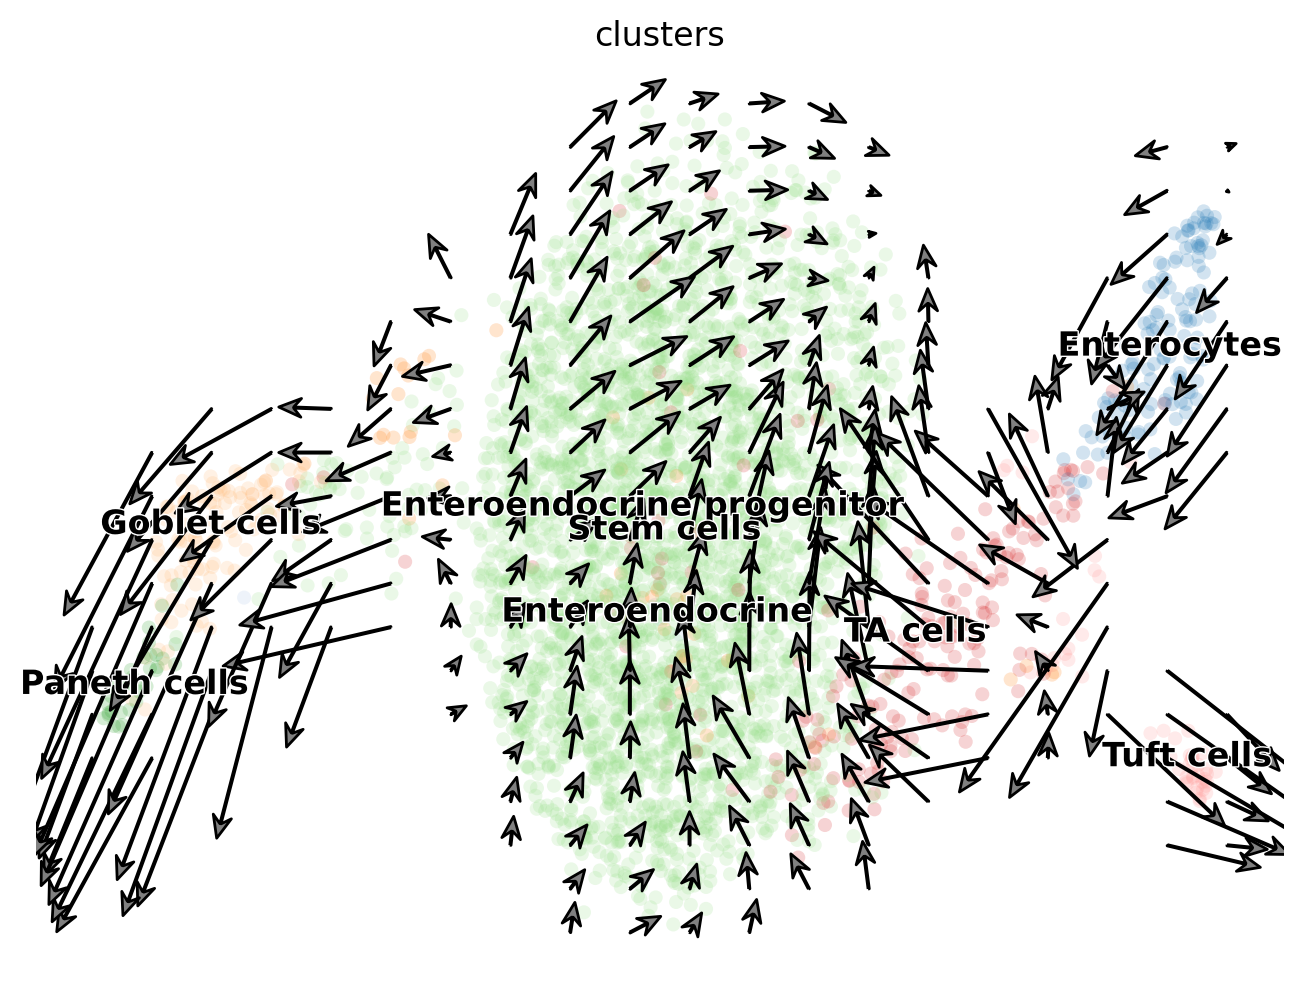

In [20]:
#Compute velocity
embed = "umap"
figure_path = f'{root}/figures/{dataset}'

fig, ax = plt.subplots(figsize=(8, 6))
embed_mean = plot_mean_vector_field(pos,
                                    adata,
                                    ax=ax,
                                    basis=embed,
                                    n_jobs=(adata.n_obs)//2000+1)

## 5. Compute performance metrics and save results

In [21]:
def save_fitting(adata, pos_train, train_idx, pos_test=None, test_idx=None):
    split = not ((pos_test is None) or (test_idx is None))
    for key in pos_train:
        k,m,n = pos_train[key].shape
        if(m>1 and n>1):
            adata.layers[f'pv_{key}'] = np.zeros((adata.n_obs,n))
            adata.layers[f'pv_{key}'][train_idx] = pos_train[key].mean(0)
            if(split):
                adata.layers[f'pv_{key}'][test_idx] = pos_test[key].mean(0)
        elif(m>1):
            adata.obs[f'pv_{key}'] = np.zeros((adata.n_obs))
            adata.obs[f'pv_{key}'][train_idx] = pos_train[key].mean(0).squeeze()
            if(split):
                adata.obs[f'pv_{key}'][test_idx] = pos_test[key].mean(0).squeeze()
        elif(n>1):
            adata.var[f'pv_{key}'] = pos_train[key].mean(0).squeeze()
        else:
            adata.uns[f'pv_{key}'] = pos_train[key]

In [22]:
adata.obsm[f"pv_velocity_{embed}"] = embed_mean
del adata.obsm[f"velocity_pyro_{embed}"]
adata.layers["pv_shat"] = adata.layers["spliced_pyro"]
adata.layers["pv_uhat"] = np.zeros(adata.shape)
adata.layers["pv_uhat"][train_idx] = pos_train["u"].mean(0)
adata.layers["pv_uhat"][test_idx] = pos_test["u"].mean(0)
del adata.layers["spliced_pyro"]
adata.layers["pv_velocity"] = adata.layers["velocity_pyro"]
del adata.layers["velocity_pyro"]

adata.obs['pv_time'] = pos['cell_time'][:,:,0].mean(0).squeeze()
adata.uns['pv_train_idx'] = train_idx
adata.uns['pv_test_idx'] = test_idx
save_fitting(adata, pos_train, train_idx, pos_test, test_idx)

err_dic = {}
mse_train, mse_test, mae_train, mae_test, logp_train, logp_test = 0,0,0,0,0,0

for i in range(pos['u'].shape[0]):
    dist_u_train = np.abs(adata.layers['Mu'][train_idx]-pos_train['u'][i])
    dist_s_train = np.abs(adata.layers['Ms'][train_idx]-pos_train['s'][i])
    dist_u_test = np.abs(adata.layers['Mu'][test_idx]-pos_test['u'][i])
    dist_s_test = np.abs(adata.layers['Ms'][test_idx]-pos_test['s'][i])
    mse_train += np.mean(dist_u_train**2+dist_s_train**2)
    mse_test += np.mean(dist_u_test**2+dist_s_test**2)
    mae_train += np.mean(dist_u_train+dist_s_train)
    mae_test += np.mean(dist_u_test+dist_s_test)
    #MLE of variance
    var_s_train, var_s_test = np.var(adata.layers['Mu'][train_idx]-pos_train['u'][i],0),np.var(adata.layers['Ms'][train_idx]-pos_train['s'][i],0)
    var_u_train, var_u_test = np.var(adata.layers['Mu'][test_idx]-pos_test['u'][i],0),np.var(adata.layers['Ms'][test_idx]-pos_test['s'][i],0)
    logp_train += -dist_u_train**2/(2*var_u_train)-dist_s_train**2/(2*var_s_train) \
                - 0.5*np.log(var_u_train) - 0.5*np.log(var_s_train) - np.log(2*np.pi)
    logp_test += -dist_u_test**2/(2*var_u_test)-dist_s_test**2/(2*var_s_test) \
                - 0.5*np.log(var_u_test) - 0.5*np.log(var_s_test) - np.log(2*np.pi)

In [23]:
err_dic['MSE Train'] = mse_train / n_sample
err_dic['MSE Test'] = mse_test / n_sample
err_dic['MAE Train'] = mae_train / n_sample
err_dic['MAE Test'] = mae_test / n_sample
err_dic['LL Train'] = logp_train / n_sample
err_dic['LL Test'] = logp_test / n_sample
adata.uns['err'] = err_dic

In [24]:
err_dic

{'MSE Train': 1.1285861253738403,
 'MSE Test': 0.9365366419156392,
 'MAE Train': 0.3428914477427801,
 'MAE Test': 0.32849856913089753,
 'LL Train': array([[ 1.9854900e+00, -3.1623340e+02,  7.0355457e-01, ...,
          2.9405744e+00, -1.6000055e+00,  3.8949199e+00],
        [ 2.4957173e-02, -4.5065585e+02,  1.1404004e+00, ...,
          2.9258573e+00,  1.6707155e+00,  3.6720722e+00],
        [ 9.7894394e-01, -8.3130927e+02,  1.0055510e+00, ...,
          4.0859649e-01,  6.7526527e-02,  2.6022203e+00],
        ...,
        [ 1.7491190e+00, -3.7515543e+02,  1.2358925e+00, ...,
          2.8872371e+00, -2.8683329e+00,  3.4179480e+00],
        [ 1.2234910e+00, -6.9875079e+02,  1.3291259e+00, ...,
          3.4251049e+00, -4.5830588e+00,  4.9779403e-01],
        [ 1.6355208e+00, -1.7806796e+03,  9.6186697e-01, ...,
          3.3393140e+00,  1.4286605e+00,  3.8477716e+00]], dtype=float32),
 'LL Test': array([[ 1.4839702 , -4.1733465 ,  1.1514617 , ...,  3.1658342 ,
          1.5478731 ,  3.0

## Write to disk and plot results

In [25]:
data_path = f'{data_path_base}/pyro/continuous/{dataset}'
os.makedirs(data_path, exist_ok=True)
adata.write_h5ad(f'{data_path}/{dataset}.h5ad')

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/IO_EU/pv_vel_stream_normal.png


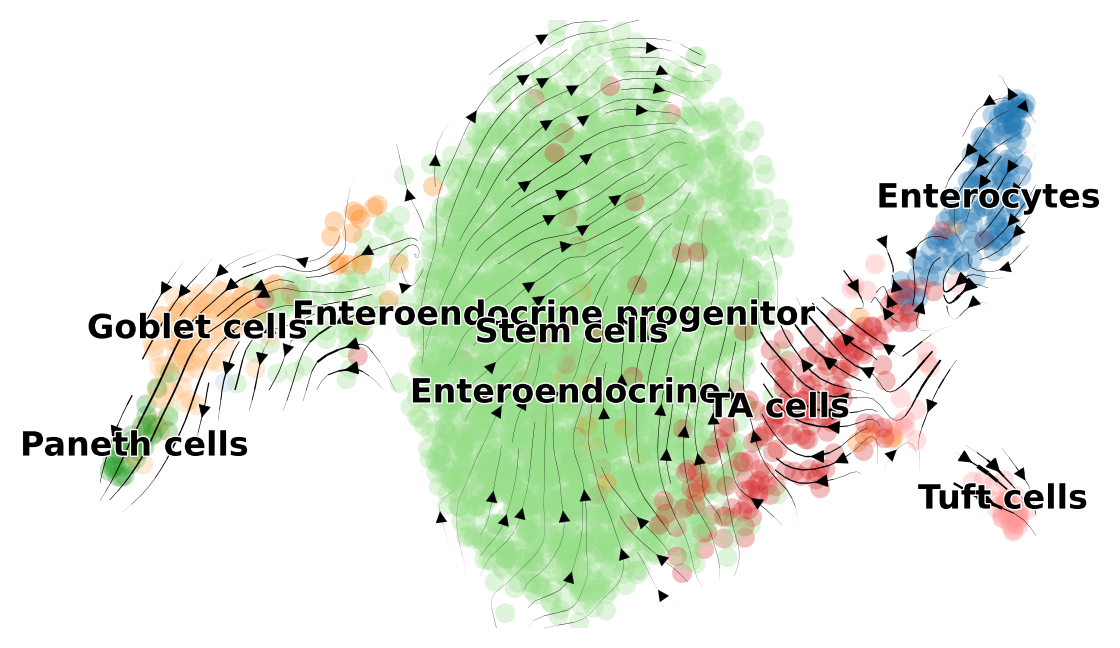

In [26]:
scv.pl.velocity_embedding_stream(adata,
                                 basis=embed,
                                 title='',
                                 vkey='pv_velocity',
                                 save=f'{figure_path}/pv_vel_stream_normal.png')

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/IO_EU/pv_time_normal.png


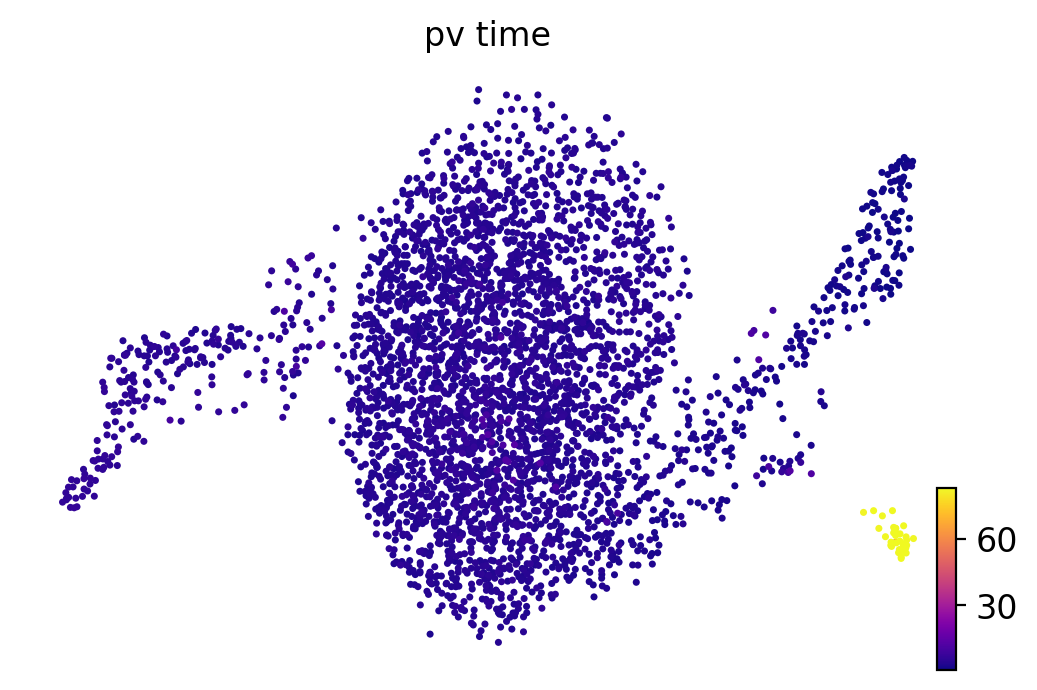

In [27]:
scv.pl.scatter(adata, basis=embed, color='pv_time', color_map='plasma', dpi=100, save=f'{figure_path}/pv_time_normal.png')